<a href="https://colab.research.google.com/github/Stylianos29/NMR-Nematic-Scaling/blob/main/Jupyter%20Notebooks/Tauc_Power_Law_Distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
#@title Dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pprint
import os
import ast
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
#@title User input

# Experimental values of parameters
W1maxTauC = 120 #Hz
gyromagnetic_ratio = 7.2919e6 #Hz/Teslas
magnetic_field = 11.7 #Teslas
omega_Larmor = gyromagnetic_ratio * magnetic_field
tauC_resonance = 1/omega_Larmor
kB = 8.617333262145e-5 #units: eV/K

# User input
temperature_value = 26 # Critical temperature at about 25K
critical_exponent = 0.9 #initial critical exponent value
tauC_lower_bound = 0.5*tauC_resonance # initial
tauC_upper_bound = 1e1 #seconds
W1max_safety_margin = 0.99*W1maxTauC
time_scale = 1e-9 #nano-seconds
# the range of investigation
tauC_lower_bound_range_min = 0.005*tauC_resonance
tauC_lower_bound_range_max = tauC_resonance
tauC_attempt = 1e-12

# Number of bins for the W1 distribution histogram
number_of_bins_distribution = 100000 # FYI 100 bins are already many

print('T = {:.2f} K'.format(temperature_value))
print('W1max = {:.2f} Hz'.format(W1maxTauC))
print('ωL = {:.2f} MHz'.format(omega_Larmor/1e6))
print('Resonance τC = {:.2f} ns'.format(tauC_resonance/time_scale))

T = 26.00 K
W1max = 120.00 Hz
ωL = 85.32 MHz
Resonance τC = 11.72 ns


In [25]:
#@title Functions Definitions

# Choice of a test function for the oscillation times
def tauC_distribution_function(tauC, *distribution_arguments):
    lower_cut_off = distribution_arguments[0]
    exponent = distribution_arguments[1]
    return np.heaviside(tauC-lower_cut_off, 0)*tauC**(-exponent)

# Symbolic relations
#Stretched exponential recovery function for I=1/2
def stretched_recovery_function(x, M0, phi, alpha, beta):
    return ( M0*(1 - 2*phi*( (9/10)*np.exp(-pow((6*alpha*x), beta) ) -
                                (1/10)*np.exp(-pow((alpha*x), beta) ) ) ) )

def W1_relation_tauC(tauC, W1maxTauC, omega_Larmor):
    return 2*W1maxTauC * (omega_Larmor*tauC)/(1+(omega_Larmor*tauC)**2)

def tauC_relation_W1_minus(W1, W1maxTauC, omega_Larmor):
    ratio_W1 = W1maxTauC/W1
    return ( ratio_W1 - np.sqrt(ratio_W1**2-1) )/omega_Larmor
    
def tauC_relation_W1_plus(W1, W1maxTauC, omega_Larmor):
    ratio_W1 = W1maxTauC/W1
    return ( ratio_W1 + np.sqrt(ratio_W1**2-1) )/omega_Larmor

# def W1_distribution_from_tauC(W1, upper_bound, cue,
#                               *tauC_distribution_function_arguments):
#     ratio = upper_bound/W1
#     minus_branch = ( tauC_distribution_function(tauC_relation_W1_minus(
#         W1, upper_bound, omega_Larmor), *tauC_distribution_function_arguments)
#              * (1/(omega_Larmor*upper_bound)) *
#                                 (- ratio**2 + ratio**3/np.sqrt(ratio**2-1)) )
#     plus_branch = ( tauC_distribution_function(tauC_relation_W1_plus(
#         W1, upper_bound, omega_Larmor), *tauC_distribution_function_arguments)
#                 * (1/(omega_Larmor*upper_bound)) *
#                                     (ratio**2 + ratio**3/np.sqrt(ratio**2-1)) )
#     return cue*minus_branch + plus_branch


def W1_distribution_from_tauC_minus(W1, upper_bound,
                              *tauC_distribution_function_arguments):
    ratio = upper_bound/W1
    minus_branch = ( tauC_distribution_function(tauC_relation_W1_minus(
        W1, upper_bound, omega_Larmor), *tauC_distribution_function_arguments)
             * (1/(omega_Larmor*upper_bound)) *
                                (- ratio**2 + ratio**3/np.sqrt(ratio**2-1)) )
    
    return minus_branch

def W1_distribution_from_tauC_plus(W1, upper_bound,
                              *tauC_distribution_function_arguments):
    ratio = upper_bound/W1
    plus_branch = ( tauC_distribution_function(tauC_relation_W1_plus(
        W1, upper_bound, omega_Larmor), *tauC_distribution_function_arguments)
                * (1/(omega_Larmor*upper_bound)) *
                                    (ratio**2 + ratio**3/np.sqrt(ratio**2-1)) )
    return plus_branch

# Distribution construction
def histogram_bins(lower_bound, upper_bound, number_of_bins):
    bin_width = (upper_bound - lower_bound)/number_of_bins
    bins_array = np.array( [ ( lower_bound + bin_width * (j + 0*1/2) )
                                            for j in range(number_of_bins) ] )
    return bins_array

def histogram_distribution_values(histogram_bins, distribution_function,
                                            *distribution_function_arguments):
    bins_width = (max(histogram_bins) - min(histogram_bins))/(
                                                        len(histogram_bins)-1)
    histogram_bins = np.array(histogram_bins)
    non_normalized_distribution_values = distribution_function(histogram_bins,
                                            *distribution_function_arguments)
    # integral = np.sum( non_normalized_distribution_values)*bins_width
    #return non_normalized_distribution_values/integral
    return non_normalized_distribution_values

#normalization_check
def distribution_integral(histogram_bins_array, histogram_values_array):
    histogram_bins_array = np.array(histogram_bins_array)
    histogram_values_array = np.array(histogram_values_array)
    bin_width = (max(histogram_bins_array) - min(histogram_bins_array))/(
                                                len(histogram_bins_array)-1)
    return np.sum(histogram_values_array)*bin_width

# Plotting
def plot_histogram(histogram_bins, histogram_values, histogram_title = '',
        x_axis_label = '', y_axis_label = '', x_axis_scale = 'linear',
            y_axis_scale = 'linear'):
    fig, ax = plt.subplots()
    ax.scatter(histogram_bins, histogram_values, marker=".")
    ax.grid()
    ax.set_xscale(x_axis_scale)
    ax.set_yscale(y_axis_scale)
    ax.set_title(histogram_title, pad=15)
    ax.set(xlabel = x_axis_label, ylabel = y_axis_label)
    plt.show()

# Magnetization recovery function
def recovery_function(x):
    return 1 - 0.9 * np.exp(-6*x) - 0.1 * np.exp(-x)

# Magnetization integral definition
def magnetization_integral(W1_histogram_bins, W1_histogram_values,
                                                                recovery_time):
    bins_width = (max(W1_histogram_bins) - min(W1_histogram_bins))/(
                                                    len(W1_histogram_bins)-1)
    return np.sum(W1_histogram_values*np.abs(recovery_function(W1_histogram_bins
                                                    *recovery_time)))*bins_width
    # recovery_function_array = recovery_function(W1_histogram_bins*recovery_time)
    # recovery_function_array[recovery_function_array<0]=0
    # return np.sum(W1_histogram_values*recovery_function_array)*bins_width

def RSS_calculation(numerical_data, real_data):
    return np.sum( (numerical_data - real_data)**2 )

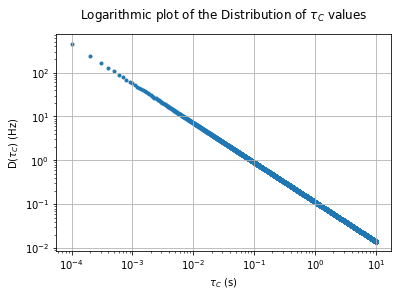

Normalization check: total sum = 1.00


Initial lower τC cut-off = 1.00e-12 s
Initial upper τC cut-off = 1.00e+01 s
Initial exponent value = 0.90


In [26]:
#@title Distribution of $\tau_c$ values

tauC_histogram_bins = histogram_bins(tauC_attempt, tauC_upper_bound, 
                                                number_of_bins_distribution)
tauC_distribution_histogram = histogram_distribution_values(
      tauC_histogram_bins, tauC_distribution_function,
        tauC_lower_bound, critical_exponent)

tauC_distribution_integral_initial = distribution_integral(
                        tauC_histogram_bins, tauC_distribution_histogram)

tauC_distribution_histogram = (tauC_distribution_histogram
                               /tauC_distribution_integral_initial)

lower_bound_index = len(tauC_histogram_bins[tauC_histogram_bins<=tauC_lower_bound])

plot_histogram(tauC_histogram_bins[lower_bound_index:],
               tauC_distribution_histogram[lower_bound_index:],
histogram_title = 'Logarithmic plot of the Distribution of ${\\tau}_C$ values',
        x_axis_label = '${\\tau}_C$ (s)',
            y_axis_label = 'D(${\\tau}_C$) (Hz)', x_axis_scale = 'log',
              y_axis_scale = 'log')

print('Normalization check: total sum = {:.2f}'.format(distribution_integral(
                          tauC_histogram_bins, tauC_distribution_histogram)))
print('\n')
print('Initial lower τC cut-off = {:.2e} s'.format(tauC_histogram_bins[0]))
print('Initial upper τC cut-off = {:.2e} s'.format(tauC_histogram_bins[-1]))
print('Initial exponent value = {:.2f}'.format(critical_exponent))


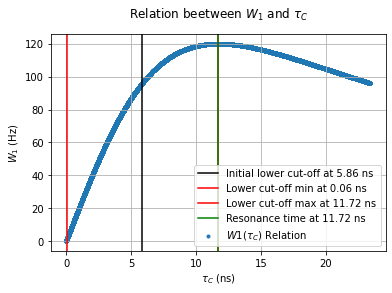

In [27]:
#@title Relation beetween $W_1$ and $\tau_C$: $W_1 = 2 W_1^{\max} \frac{\omega_L \tau_C}{1 + (\omega_L \tau_C)^2}$

tauC_min = tauC_attempt
tauC_max = 2.0*tauC_resonance
tauC_bins = histogram_bins(tauC_min, tauC_max, number_of_bins_distribution)
W1_values = W1_relation_tauC(tauC_bins, W1maxTauC, omega_Larmor)

fig, ax = plt.subplots()
ax.scatter(tauC_bins/time_scale, W1_values, marker=".", label='$W1(\\tau_C)$ Relation ')
ax.grid()
ax.axvline(x=tauC_lower_bound/time_scale, color='black',
           linestyle='-', label='Initial lower cut-off at {:.2f} ns'.format(
               tauC_lower_bound/time_scale))
ax.axvline(x=tauC_lower_bound_range_min/time_scale, color='red',
           linestyle='-', label='Lower cut-off min at {:.2f} ns'.format(
               tauC_lower_bound_range_min/time_scale))
ax.axvline(x=tauC_lower_bound_range_max/time_scale, color='red', linestyle='-',
      label='Lower cut-off max at {:.2f} ns'.format(tauC_lower_bound_range_max/time_scale))
ax.axvline(x=tauC_resonance/time_scale, color='green', linestyle='-',
           label='Resonance time at {:.2f} ns'.format(tauC_resonance/time_scale))
ax.set_title('Relation beetween $W_1$ and $\\tau_C$', pad=15)
ax.set(xlabel = '${\\tau}_C$ (ns)', ylabel = '$W_1$ (Hz)')
plt.legend()
plt.show()

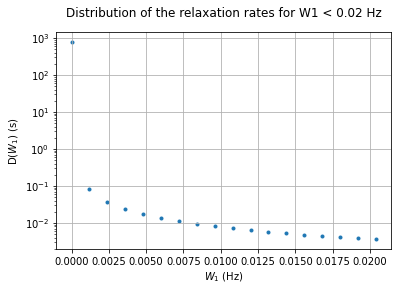

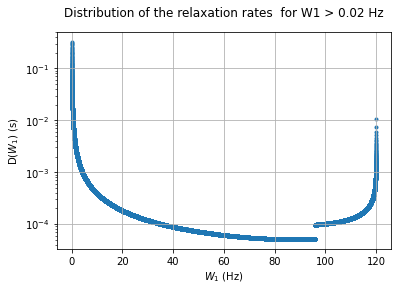

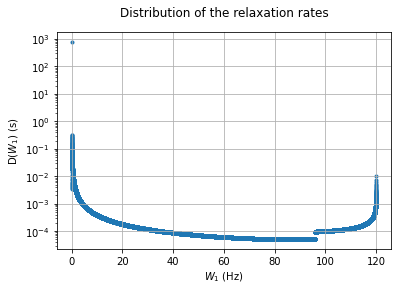

D(W1=2.81e-07 Hz) = 795.53 s
D(W1=120.00 Hz) = 0.01 s
Lower cut-off corresponds to W1 = 96.00 Hz


Normalization check: Total sum = 1.00


In [28]:
#@title Distribution of the relaxation rates

tauC_intermediate = tauC_relation_W1_plus(W1_relation_tauC(
    tauC_histogram_bins[0], W1maxTauC, omega_Larmor), W1maxTauC,omega_Larmor)
tauC_intermediate_index = (len(tauC_histogram_bins)
  -len(tauC_histogram_bins[tauC_histogram_bins > tauC_intermediate]))
tauC_distribution_integral_lower = distribution_integral(
    tauC_histogram_bins[tauC_intermediate_index:],
      tauC_distribution_histogram[tauC_intermediate_index:])
tauC_distribution_integral_upper = distribution_integral(
    tauC_histogram_bins[:tauC_intermediate_index],
      tauC_distribution_histogram[:tauC_intermediate_index])

W1_lower_bound_minus = W1_relation_tauC(tauC_histogram_bins[0], W1maxTauC,
                                                              omega_Larmor)
W1_lower_bound_plus = W1_relation_tauC(tauC_histogram_bins[-1], W1maxTauC,
                                                              omega_Larmor)

W1_intermediate = max(W1_lower_bound_minus, W1_lower_bound_plus)
W1_lower_bound = min(W1_lower_bound_minus, W1_lower_bound_plus) #0.0001*W1_intermediate

W1_histogram_bins = np.array(histogram_bins(W1_lower_bound, W1maxTauC,
                                                number_of_bins_distribution))

W1_distribution_histogram_lower = histogram_distribution_values(
    W1_histogram_bins[W1_histogram_bins < W1_intermediate],
      W1_distribution_from_tauC_plus, W1maxTauC,
          tauC_lower_bound, critical_exponent)

W1_distribution_histogram_upper_minus = histogram_distribution_values(
    W1_histogram_bins[W1_histogram_bins > W1_intermediate],
      W1_distribution_from_tauC_minus, W1maxTauC,
          tauC_lower_bound, critical_exponent)

W1_distribution_histogram_upper_plus = histogram_distribution_values(
    W1_histogram_bins[W1_histogram_bins > W1_intermediate],
      W1_distribution_from_tauC_plus, W1maxTauC,
          tauC_lower_bound, critical_exponent)

W1_distribution_histogram_upper = (W1_distribution_histogram_upper_plus
                                   + W1_distribution_histogram_upper_minus)

W1_distribution_histogram_lower_integral = distribution_integral(W1_histogram_bins[W1_histogram_bins < W1_intermediate], W1_distribution_histogram_lower)
W1_distribution_histogram_upper_integral = distribution_integral(W1_histogram_bins[W1_histogram_bins > W1_intermediate], W1_distribution_histogram_upper)

W1_distribution_histogram_lower = W1_distribution_histogram_lower*tauC_distribution_integral_lower/W1_distribution_histogram_lower_integral
W1_distribution_histogram_upper = W1_distribution_histogram_upper*tauC_distribution_integral_upper/W1_distribution_histogram_upper_integral

W1_distribution_histogram = np.concatenate([W1_distribution_histogram_lower,
                                            W1_distribution_histogram_upper])

W1_distribution_integral_initial = distribution_integral(W1_histogram_bins,
                                                  W1_distribution_histogram)
W1_distribution_histogram = (W1_distribution_histogram
                                       /W1_distribution_integral_initial)

plot_histogram(W1_histogram_bins[W1_histogram_bins < W1_intermediate],
            W1_distribution_histogram_lower,
    histogram_title = 'Distribution of the relaxation rates for W1 < {:.2f} Hz'.format(W1_intermediate),
        x_axis_label = '$W_1$ (Hz)', y_axis_label = 'D($W_1$) (s)',# x_axis_scale = 'log',
              y_axis_scale = 'log')

plot_histogram(W1_histogram_bins[W1_histogram_bins > W1_intermediate],
            W1_distribution_histogram_upper,
    histogram_title = 'Distribution of the relaxation rates  for W1 > {:.2f} Hz'.format(W1_intermediate),
        x_axis_label = '$W_1$ (Hz)', y_axis_label = 'D($W_1$) (s)',# x_axis_scale = 'log',
              y_axis_scale = 'log')

plot_histogram(W1_histogram_bins,
               W1_distribution_histogram,
    histogram_title = 'Distribution of the relaxation rates',
        x_axis_label = '$W_1$ (Hz)', y_axis_label = 'D($W_1$) (s)',# x_axis_scale = 'log',
              y_axis_scale = 'log')

print("D(W1={:.2e} Hz) = {:.2f} s".format(W1_histogram_bins[0], W1_distribution_histogram[0]))
print("D(W1={:.2f} Hz) = {:.2f} s".format(W1_histogram_bins[-1], W1_distribution_histogram[-1]))
print('Lower cut-off corresponds to W1 = {:.2f} Hz'.format(
    W1_relation_tauC(tauC_lower_bound, W1maxTauC, omega_Larmor)) )

print('\n')
print('Normalization check: Total sum = {:.2f}'.format(
    distribution_integral(W1_histogram_bins, W1_distribution_histogram)))

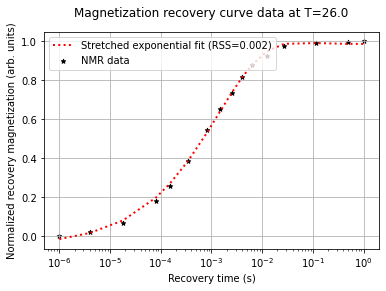

In [29]:
#@title Importing actual data

NMR_processed_data_output_full_path = os.path.join('/content/drive/My Drive',
                                          'Colab Notebooks/NMR_normalized_data')

# Passing the content of the .csv file to a Pandas DataFrame
magnetization_recovery_normalized_data = pd.read_csv(
    os.path.join(NMR_processed_data_output_full_path,
                                "Normalized_raw_data_x=0.05898_H=11.7T.csv") )

# Importing the Magnetization recovery dictionary to a text file
magnetization_recovery_text_file_full_path = os.path.join(
    NMR_processed_data_output_full_path, "Recovery_magnetization-time_pairs_"+
        "per_temperature_dictionary_x=0.05898_H=11.7T.txt")
magnetization_recovery_text_file = open(
    magnetization_recovery_text_file_full_path, "r")
magnetization_recovery_dictionary = magnetization_recovery_text_file.read()
magnetization_curve_dictionary = ast.literal_eval(
                                        magnetization_recovery_dictionary)
magnetization_recovery_text_file.close()
#Print statements
# pprint.pprint(magnetization_curve_dictionary)

# Importing the fit parameters for normalized data text file
fit_parameters_for_normalized_data_text_file_full_path = os.path.join(
    NMR_processed_data_output_full_path,
      "Fit_parameters_for_normalized_data_dictionary_x=0.05898_H=11.7T.txt")
fit_parameters_for_normalized_data_text_file = open(
    fit_parameters_for_normalized_data_text_file_full_path, "r")
fit_parameters_for_normalized_data_dictionary = fit_parameters_for_normalized_data_text_file.read()
fit_parameters_for_normalized_data_dictionary = ast.literal_eval(fit_parameters_for_normalized_data_dictionary)
fit_parameters_for_normalized_data_text_file.close()
# pprint.pprint(fit_parameters_for_normalized_data_dictionary)

temperature_value = float(temperature_value)
recovery_times = np.array(magnetization_recovery_normalized_data[
                    magnetization_curve_dictionary[temperature_value][0]])
recovery_times = recovery_times[np.logical_not(np.isnan( recovery_times ))]
magnetization_curve = np.array(magnetization_recovery_normalized_data[
                    magnetization_curve_dictionary[temperature_value][1]])
magnetization_curve = magnetization_curve[np.logical_not(np.isnan(
                                                        magnetization_curve))]

# Importing the parameter estimetes for the 
fit_parameters_for_normalized_data = np.array(fit_parameters_for_normalized_data_dictionary[temperature_value])[:,0]

magnetization_curve_stretched_exponential = np.array(stretched_recovery_function(recovery_times,*fit_parameters_for_normalized_data))
RSS_stretched_exponential = np.sum((magnetization_curve - magnetization_curve_stretched_exponential)**2)

# plotting
fig, ax = plt.subplots()
ax.scatter(recovery_times, magnetization_curve, s=20, color='black', marker="*")
ax.plot(recovery_times, stretched_recovery_function(recovery_times,*fit_parameters_for_normalized_data), linestyle=':', linewidth=2, color='red')
ax.grid()
ax.set_xscale('log')
ax.set_title('Magnetization recovery curve data at T='+'{}'.format(temperature_value), pad=15)
ax.set(xlabel='Recovery time (s)', ylabel='Normalized recovery magnetization (arb. units)')
ax.legend(['Stretched exponential fit (RSS={:.3f})'.format(RSS_stretched_exponential), 'NMR data'], loc='upper left')
plt.show()

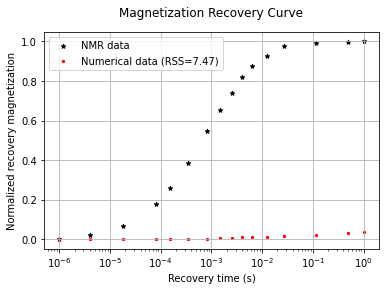

In [30]:
#@title Comparing numerical values with actual ones

# Calculating numerically the recovery magnetization values
magnetization_curve_numerical = [ magnetization_integral(W1_histogram_bins,
  W1_distribution_histogram, recovery_time) for recovery_time in recovery_times]

RSS = RSS_calculation(magnetization_curve_numerical, magnetization_curve)

# plotting
fig, ax = plt.subplots()

ax.scatter(recovery_times, magnetization_curve, s=20, color='black',
                                                                    marker="*")
ax.scatter(recovery_times, magnetization_curve_numerical, s=20, color='red',
                                                                    marker=".")

ax.grid()
ax.set_xscale('log')

ax.set_title('Magnetization Recovery Curve', pad=15)
ax.set(xlabel='Recovery time (s)', ylabel='Normalized recovery magnetization')

ax.legend(['NMR data', 'Numerical data (RSS={:.2f})'.format(RSS)],
                                                            loc='upper left')
plt.show()

In [31]:
#@title Invastigating optimal parameters

#input
number_of_exploration_attempts = 7

tauC_lower_bound_range_array = np.array( [ (tauC_lower_bound_range_min +
  ((tauC_lower_bound_range_max - tauC_lower_bound_range_min)/
   number_of_exploration_attempts)*j)
    for j in range(number_of_exploration_attempts) ] )

critical_exponent_range_max = 4
critical_exponent_range_min = 0.1
critical_exponent_array = np.array( [ (critical_exponent_range_min +
  ((critical_exponent_range_max - critical_exponent_range_min)/
    number_of_exploration_attempts)*j)
    for j in range(number_of_exploration_attempts) ] )

print('Exploration limits:')
print('- Lower cut-off values {:.2f} - {:.2f} ns:'.format(
    tauC_lower_bound_range_array[0]/time_scale,
      tauC_lower_bound_range_array[-1]/time_scale))
print('- Exponent values {:.2f} - {:.2f}:'.format(
    critical_exponent_array[0], critical_exponent_array[-1]))

# Construct two arrays with the W1min and critical exponent values to be
# investigated make sure that the invastigated ranges starts above W1min = 0
RSS_values_array = np.zeros((number_of_exploration_attempts,
                             number_of_exploration_attempts))

#make sure that the invastigated ranges starts above critical_exponent = 0

# Calculating the RSS array values
for i in range(number_of_exploration_attempts):
  critical_exponent = critical_exponent_array[i]
  for j in range(number_of_exploration_attempts):
    tauC_lower_bound = tauC_lower_bound_range_array[j]

    W1_distribution_histogram_lower = histogram_distribution_values(
        W1_histogram_bins[W1_histogram_bins < W1_intermediate],
          W1_distribution_from_tauC_plus, W1maxTauC,
              tauC_lower_bound, critical_exponent)

    W1_distribution_histogram_upper_minus = histogram_distribution_values(
        W1_histogram_bins[W1_histogram_bins > W1_intermediate],
          W1_distribution_from_tauC_minus, W1maxTauC,
              tauC_lower_bound, critical_exponent)

    W1_distribution_histogram_upper_plus = histogram_distribution_values(
        W1_histogram_bins[W1_histogram_bins > W1_intermediate],
          W1_distribution_from_tauC_plus, W1maxTauC,
              tauC_lower_bound, critical_exponent)

    W1_distribution_histogram_upper = (W1_distribution_histogram_upper_plus
                                      + W1_distribution_histogram_upper_minus)

    W1_distribution_histogram_lower_integral = distribution_integral(W1_histogram_bins[W1_histogram_bins < W1_intermediate], W1_distribution_histogram_lower)
    W1_distribution_histogram_upper_integral = distribution_integral(W1_histogram_bins[W1_histogram_bins > W1_intermediate], W1_distribution_histogram_upper)

    if ((tauC_distribution_integral_lower>0)
        and (W1_distribution_histogram_lower_integral>0)):
      W1_distribution_histogram_lower = W1_distribution_histogram_lower/(
          W1_distribution_histogram_lower_integral
            /tauC_distribution_integral_lower)
    else:
      W1_distribution_histogram_lower = W1_distribution_histogram_lower*0
    
    if ((tauC_distribution_integral_upper>0) 
        and (W1_distribution_histogram_upper_integral>0)):
      W1_distribution_histogram_upper = W1_distribution_histogram_upper/(
          W1_distribution_histogram_upper_integral
            /tauC_distribution_integral_upper)
    else:
        W1_distribution_histogram_upper = W1_distribution_histogram_upper*0

    W1_distribution_histogram = np.concatenate([W1_distribution_histogram_lower,
                                                W1_distribution_histogram_upper])

    W1_distribution_integral_initial = distribution_integral(W1_histogram_bins,
                                                      W1_distribution_histogram)
    W1_distribution_histogram = (W1_distribution_histogram
                                          /W1_distribution_integral_initial)


    magnetization_curve_numerical = [ magnetization_integral(
            W1_histogram_bins, W1_distribution_histogram, recovery_time)
                                    for recovery_time in recovery_times]
    
    RSS_values_array[i][j] = RSS_calculation(magnetization_curve_numerical,
                                                    magnetization_curve)


Exploration limits:
- Lower cut-off values 0.06 - 10.06 ns:
- Exponent values 0.10 - 3.44:


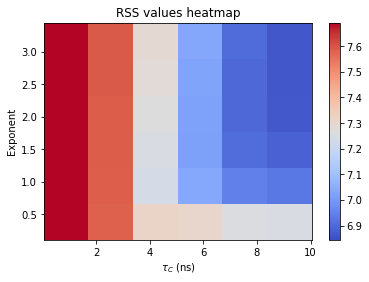

Minimum RSS value: 6.843
Maximum RSS value: 7.691


In [32]:
#@title Plotting the RSS heatmap

b, a = np.meshgrid(critical_exponent_array,
                   tauC_lower_bound_range_array/time_scale)

c = RSS_values_array
# c = c[:-1, :-1]
l_a = a.min()
r_a = a.max()
l_b = b.min()
r_b = b.max()
l_c, r_c = np.amin(c), np.max(c)

figure, axes = plt.subplots()

c = axes.pcolormesh(a, b, c, cmap='coolwarm', vmin=l_c, vmax=r_c) #0.05
axes.set_title('RSS values heatmap')
axes.set_xlabel('$\\tau_C$ (ns)')
axes.set_ylabel('Exponent')
axes.axis([l_a, r_a, l_b, r_b])
figure.colorbar(c)

plt.show()

print("Minimum RSS value: {:.3f}".format(l_c))
print("Maximum RSS value: {:.3f}".format(r_c))

Optimal lower bound W1 value: 8.389 ns and critical exponent value: 3.44


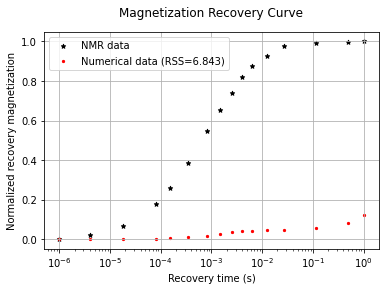

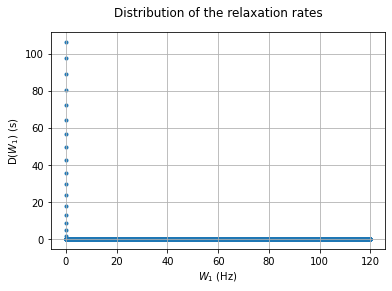

D(W1=2.81e-07 Hz) = 0.00 s
D(W1=120.00 Hz) = 0.18 s
Lower cut-off corresponds to W1 = 113.59 Hz


Normalization check: Total sum = 1.00


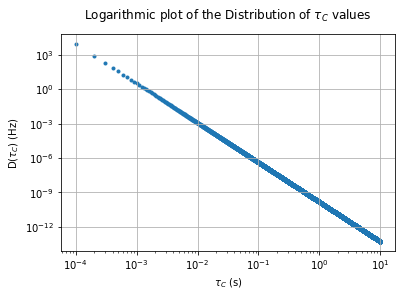

RSS check: 6.84
Normalization check: total sum = 1.00


Initial lower τC cut-off = 1.00e-12 s
Initial upper τC cut-off = 1.00e+01 s
Initial exponent value = 3.44


In [33]:
#@title Plotting the numerical sets with the lowest RSS

RSS_minimum = np.array(np.where(RSS_values_array == np.amin(RSS_values_array)))
RSS = RSS_values_array[ RSS_minimum[0][0] ][ RSS_minimum[1][0] ]

tauC_lower_bound = tauC_lower_bound_range_array[ RSS_minimum[1][0] ]
critical_exponent = critical_exponent_array[ RSS_minimum[0][0] ]

print("Optimal lower bound W1 value: {:.3f} ns".format(
    tauC_lower_bound/time_scale)+
      " and critical exponent value: {:.2f}".format(critical_exponent))

W1_distribution_histogram_lower = histogram_distribution_values(
    W1_histogram_bins[W1_histogram_bins < W1_intermediate],
      W1_distribution_from_tauC_plus, W1maxTauC,
          tauC_lower_bound, critical_exponent)

W1_distribution_histogram_upper_minus = histogram_distribution_values(
    W1_histogram_bins[W1_histogram_bins > W1_intermediate],
      W1_distribution_from_tauC_minus, W1maxTauC,
          tauC_lower_bound, critical_exponent)

W1_distribution_histogram_upper_plus = histogram_distribution_values(
    W1_histogram_bins[W1_histogram_bins > W1_intermediate],
      W1_distribution_from_tauC_plus, W1maxTauC,
          tauC_lower_bound, critical_exponent)

W1_distribution_histogram_upper = (W1_distribution_histogram_upper_plus
                                   + W1_distribution_histogram_upper_minus)

W1_distribution_histogram_lower_integral = distribution_integral(W1_histogram_bins[W1_histogram_bins < W1_intermediate], W1_distribution_histogram_lower)
W1_distribution_histogram_upper_integral = distribution_integral(W1_histogram_bins[W1_histogram_bins > W1_intermediate], W1_distribution_histogram_upper)

W1_distribution_histogram_lower = W1_distribution_histogram_lower*tauC_distribution_integral_lower/W1_distribution_histogram_lower_integral
W1_distribution_histogram_upper = W1_distribution_histogram_upper*tauC_distribution_integral_upper/W1_distribution_histogram_upper_integral

W1_distribution_histogram = np.concatenate([W1_distribution_histogram_lower,
                                            W1_distribution_histogram_upper])

W1_distribution_integral_initial = distribution_integral(W1_histogram_bins,
                                                  W1_distribution_histogram)
W1_distribution_histogram = (W1_distribution_histogram
                                       /W1_distribution_integral_initial)

magnetization_curve_numerical = [ magnetization_integral(
        W1_histogram_bins, W1_distribution_histogram, recovery_time)
                                for recovery_time in recovery_times]


fig, ax = plt.subplots()
ax.scatter(recovery_times, magnetization_curve, s=20, color='black',
                                                                  marker="*")
ax.scatter(recovery_times, magnetization_curve_numerical, s=20, color='red',
                                                                  marker=".")
ax.grid()
ax.set_xscale('log')
ax.set_title('Magnetization Recovery Curve', pad=15)
ax.set(xlabel='Recovery time (s)', ylabel='Normalized recovery magnetization')
ax.legend(['NMR data', 'Numerical data (RSS={:.3f})'.format(RSS)],
                                                            loc='upper left')
plt.show()

# plot_histogram(W1_histogram_bins[W1_histogram_bins < W1_intermediate],
#             W1_distribution_histogram_lower,
#     histogram_title = 'Distribution of the relaxation rates for W1 < {:.2f} Hz'.format(W1_intermediate),
#         x_axis_label = '$W_1$ (Hz)', y_axis_label = 'D($W_1$) (s)'),# x_axis_scale = 'log',
#               #y_axis_scale = 'log')

# plot_histogram(W1_histogram_bins[W1_histogram_bins > W1_intermediate],
#             W1_distribution_histogram_upper,
#     histogram_title = 'Distribution of the relaxation rates  for W1 > {:.2f} Hz'.format(W1_intermediate),
#         x_axis_label = '$W_1$ (Hz)', y_axis_label = 'D($W_1$) (s)'),# x_axis_scale = 'log',
#               #y_axis_scale = 'log')

plot_histogram(W1_histogram_bins,
               W1_distribution_histogram,
    histogram_title = 'Distribution of the relaxation rates',
        x_axis_label = '$W_1$ (Hz)', y_axis_label = 'D($W_1$) (s)'),# x_axis_scale = 'log',
              #y_axis_scale = 'log')

print("D(W1={:.2e} Hz) = {:.2f} s".format(W1_histogram_bins[0], W1_distribution_histogram[0]))
print("D(W1={:.2f} Hz) = {:.2f} s".format(W1_histogram_bins[-1], W1_distribution_histogram[-1]))
print('Lower cut-off corresponds to W1 = {:.2f} Hz'.format(
    W1_relation_tauC(tauC_lower_bound, W1maxTauC, omega_Larmor)) )

print('\n')
print('Normalization check: Total sum = {:.2f}'.format(
    distribution_integral(W1_histogram_bins, W1_distribution_histogram)))

tauC_distribution_histogram = histogram_distribution_values(
      tauC_histogram_bins, tauC_distribution_function,
        tauC_lower_bound, critical_exponent)

tauC_distribution_integral_initial = distribution_integral(
                        tauC_histogram_bins, tauC_distribution_histogram)

tauC_distribution_histogram = (tauC_distribution_histogram
                               /tauC_distribution_integral_initial)

lower_bound_index = len(tauC_histogram_bins[tauC_histogram_bins<=tauC_lower_bound])

plot_histogram(tauC_histogram_bins[lower_bound_index:],
               tauC_distribution_histogram[lower_bound_index:],
histogram_title = 'Logarithmic plot of the Distribution of ${\\tau}_C$ values',
        x_axis_label = '${\\tau}_C$ (s)',
            y_axis_label = 'D(${\\tau}_C$) (Hz)', x_axis_scale = 'log',
              y_axis_scale = 'log')

magnetization_curve_numerical = [ magnetization_integral(W1_histogram_bins,
  W1_distribution_histogram, recovery_time) for recovery_time in recovery_times]
print('RSS check: {:.2f}'.format(RSS_calculation(magnetization_curve_numerical,
  magnetization_curve)))

print('Normalization check: total sum = {:.2f}'.format(distribution_integral(
                          tauC_histogram_bins, tauC_distribution_histogram)))
print('\n')
print('Initial lower τC cut-off = {:.2e} s'.format(tauC_histogram_bins[0]))
print('Initial upper τC cut-off = {:.2e} s'.format(tauC_histogram_bins[-1]))
print('Initial exponent value = {:.2f}'.format(critical_exponent))
